In [1]:
import asyncio
import itertools
import logging
import random
import nest_asyncio
nest_asyncio.apply()# must be run at the start of every notebook to patch the event loop to allow nesting, eg. so we can run asyncio.run from within a notebook.

In [2]:
import os
from pathlib import Path
import tempfile

from shutil import rmtree
from typing import List, Optional, Union


In [4]:
# Adjust your env variables here if nescesary

%env NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
%env NUPLAN_MAPS_ROOT=../../data/nuplan/maps
%env NUPLAN_EXP_ROOT=../../data/nuplan/exp
%env NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/
%pwd

env: NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
env: NUPLAN_MAPS_ROOT=../../data/nuplan/maps
env: NUPLAN_EXP_ROOT=../../data/nuplan/exp
env: NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/


'/home/ehdykhne/nuplan-devkit/experiments'

In [5]:
import hydra
import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf

from nuplan.common.utils.s3_utils import is_s3_path
from nuplan.planning.script.builders.simulation_builder import build_simulations
from nuplan.planning.script.builders.simulation_callback_builder import (
    build_callbacks_worker,
    build_simulation_callbacks,
)
from nuplan.planning.script.utils import run_runners, set_default_path, set_up_common_builder
from nuplan.planning.simulation.planner.abstract_planner import AbstractPlanner

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# If set, use the env. variable to overwrite the default dataset and experiment paths
set_default_path()

# If set, use the env. variable to overwrite the Hydra config
CONFIG_PATH = os.getenv('NUPLAN_HYDRA_CONFIG_PATH', 'config/simulation')

if os.environ.get('NUPLAN_HYDRA_CONFIG_PATH') is not None:
    CONFIG_PATH = os.path.join('../../../../', CONFIG_PATH)

if os.path.basename(CONFIG_PATH) != 'simulation':
    CONFIG_PATH = os.path.join(CONFIG_PATH, 'simulation')
CONFIG_NAME = 'default_simulation'

In [8]:
from tutorials.utils.tutorial_utils import construct_simulation_hydra_paths

# Location of paths with all simulation configs
BASE_CONFIG_PATH = os.path.join(os.getenv('NUPLAN_TUTORIAL_PATH', ''), '../nuplan/planning/script')
simulation_hydra_paths = construct_simulation_hydra_paths(BASE_CONFIG_PATH)

# Create a temporary directory to store the simulation artifacts

DATASET_PARAMS = [
    'scenario_builder=nuplan',  # use nuplan mini database (2.5h of 8 autolabeled logs in Las Vegas)
    'scenario_filter=val14_split ',  # initially select all scenarios in the database
#     'scenario_filter.scenario_types=[near_multiple_vehicles, on_pickup_dropoff, starting_unprotected_cross_turn, high_magnitude_jerk]',  # select scenario types
#    'scenario_filter.scenario_types=[starting_unprotected_cross_turn, near_multiple_vehicles]',  # [near_multiple_vehicles, on_pickup_dropoff, starting_unprotected_cross_turn, high_magnitude_jerk]',  # select scenario types
#    'scenario_filter.num_scenarios_per_type=2',  # use 10 scenarios per scenario type
#     'scenario_filter=one_continuous_log',  # simulate only one log
#     "scenario_filter.log_names=['2021.06.14.16.48.02_veh-12_04057_04438']",
     'scenario_filter.limit_total_scenarios=100',  # use 1 total scenarios
]
ckpt_dir = '/home/ehdykhne/Repos/nuplan-devkit/experiments/pretrained_checkpoints/pdm_offset_checkpoint.ckpt'
#'/home/sacardoz/checkpoints/urbandriver_checkpoint.ckpt'
#"/home/sacardoz/tutorial_vector_framework/training_simple_vector_experiment/train_default_simple_vector/2023.11.23.09.55.21/best_model/epoch.ckpt"
#"/home/sacardoz/training_raster_experiment/train_default_raster/2023.11.23.07.36.36/best_model/epoch.ckpt"
# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=simulation_hydra_paths.config_path)

# Compose the configuration
print(simulation_hydra_paths.config_name)
cfg = hydra.compose(config_name=simulation_hydra_paths.config_name, overrides=[
    '+simulation=open_loop_boxes',# [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents]
    #'model=pgm_hybrid_model',
#     'planner=pdm_hybrid_planner',
#     f"planner.pdm_hybrid_planner.checkpoint_path={ckpt_dir}" ,
    'planner=log_future_planner', 
    'ego_controller=perfect_tracking_controller',
    #'planner.ml_planner.model_config=${model}',
    #f'planner.ml_planner.checkpoint_path={ckpt_dir}',
    #f'observation=idm_agents_observation',
    #'observation.model_config=${model}',
    #f'observation.checkpoint_path={ckpt_dir}',
    'worker=ray_distributed',
    '+occlusion=true',
    '+occlusion.manager_type=wedge', #options: [range, shadow, wedge]
    "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
    *DATASET_PARAMS,
])

output_folder = cfg.output_dir
print(output_folder)

default_simulation
../../data/nuplan/exp/exp/simulation/open_loop_boxes/2023.12.09.19.26.39


# Now we can run with the following

Global seed set to 0


2023-12-09 19:26:42,860 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:20}  Building MultiMainCallback...
2023-12-09 19:26:42,880 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:35}  Building MultiMainCallback: 4...DONE!
2023-12-09 19:26:43,090 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2023-12-09 19:26:43,091 WARNING {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:135}  Ray is running, we will shut it down before starting again!
(wrapped_fn pid=21046) numrel agents 2
(wrapped_fn pid=21046) scenario 69038042d9085f7e
(wrapped_fn pid=21046) time elapsed false 0.024567842483520508
2023-12-09 19:26:45,764 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:78}  Starting ray local!


2023-12-09 19:26:47,386	INFO worker.py:1636 -- Started a local Ray instance.


2023-12-09 19:26:48,036 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2023-12-09 19:26:48,037 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 32
Number of GPUs per node: 4
Number of threads across all nodes: 32
2023-12-09 19:26:48,037 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2023-12-09 19:26:48,037 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  Building experiment folders...
2023-12-09 19:26:48,037 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:35}  

	Folder where all results are stored: ../../data/nuplan/exp/exp/simulation/open_loop_boxes/2023.12.09.19.26.39

2023-12-09 19:26:48,038 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:7

Ray objects: 100%|██████████| 32/32 [00:01<00:00, 21.66it/s]


2023-12-09 19:26:49,675 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:76}  Building metric engines...
2023-12-09 19:26:49,781 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:78}  Building metric engines...DONE
2023-12-09 19:26:49,781 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:82}  Building simulations from 100 scenarios...
2023-12-09 19:26:50,159 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:142}  Building simulations...DONE!
2023-12-09 19:26:50,159 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/run_simulation.py:114}  Running simulation...
2023-12-09 19:26:50,159 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:138}  Executing runners...
2023-12-09 19:26:50,159 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:82}  Starting 100 simulations using RayDistrib

Ray objects:   0%|          | 0/100 [00:00<?, ?it/s]

(wrapped_fn pid=22517) numrel agents 1
(wrapped_fn pid=22517) scenario 1863deb853a051b6
(wrapped_fn pid=22517) time elapsed false 0.07382488250732422


Ray objects:   2%|▏         | 2/100 [00:05<04:07,  2.52s/it]

(wrapped_fn pid=22512) false


Ray objects:   7%|▋         | 7/100 [00:09<01:15,  1.24it/s]

(wrapped_fn pid=22500) numrel agents 4 [repeated 4x across cluster]
(wrapped_fn pid=22500) scenario 2a1ee001593a5b12 [repeated 4x across cluster]
(wrapped_fn pid=22500) time elapsed false 0.43694329261779785 [repeated 4x across cluster]


Ray objects:   8%|▊         | 8/100 [00:11<01:32,  1.01s/it]

(wrapped_fn pid=22518) false [repeated 3x across cluster]


Ray objects:  17%|█▋        | 17/100 [00:15<00:39,  2.09it/s]

(wrapped_fn pid=22507) numrel agents 4 [repeated 9x across cluster]
(wrapped_fn pid=22512) scenario 534858c9d60955fa [repeated 8x across cluster]
(wrapped_fn pid=22512) time elapsed false 0.22110891342163086 [repeated 8x across cluster]


Ray objects:  22%|██▏       | 22/100 [00:16<00:22,  3.44it/s]

(wrapped_fn pid=22524) false [repeated 4x across cluster]


Ray objects:  25%|██▌       | 25/100 [00:17<00:21,  3.42it/s]

(wrapped_fn pid=22501) time elapsed true 0.10863089561462402


Ray objects:  26%|██▌       | 26/100 [00:20<01:09,  1.07it/s]

(wrapped_fn pid=22505) numrel agents 2 [repeated 4x across cluster]
(wrapped_fn pid=22505) scenario 3c6ac27e868a5039 [repeated 4x across cluster]
(wrapped_fn pid=22505) time elapsed false 0.5643432140350342 [repeated 4x across cluster]
(wrapped_fn pid=22504) time elapsed false 0.5643432140350342
(wrapped_fn pid=22507) false


Ray objects:  37%|███▋      | 37/100 [00:27<00:30,  2.07it/s]

(wrapped_fn pid=22518) numrel agents 2 [repeated 10x across cluster]
(wrapped_fn pid=22508) scenario 756942237cdf5a95 [repeated 9x across cluster]
(wrapped_fn pid=22508) time elapsed false 0.6897904872894287 [repeated 9x across cluster]
(wrapped_fn pid=22502) numrel agents 2
(wrapped_fn pid=22511) false


Ray objects:  47%|████▋     | 47/100 [00:32<00:32,  1.61it/s]

(wrapped_fn pid=22517) numrel agents 2 [repeated 5x across cluster]
(wrapped_fn pid=22517) scenario 7a578b7981a1532c [repeated 6x across cluster]
(wrapped_fn pid=22517) time elapsed false 0.8343558311462402 [repeated 6x across cluster]
(wrapped_fn pid=22504) false [repeated 3x across cluster]


Ray objects:  56%|█████▌    | 56/100 [00:38<00:26,  1.68it/s]

(wrapped_fn pid=22513) numrel agents 2 [repeated 5x across cluster]
(wrapped_fn pid=22513) scenario b09528b71a5451cf [repeated 5x across cluster]
(wrapped_fn pid=22513) time elapsed false 0.24632906913757324 [repeated 5x across cluster]
(wrapped_fn pid=22521) false [repeated 4x across cluster]


Ray objects:  67%|██████▋   | 67/100 [00:43<00:10,  3.11it/s]

(wrapped_fn pid=22511) numrel agents 1 [repeated 6x across cluster]
(wrapped_fn pid=22511) scenario bc552fcf837c597e [repeated 6x across cluster]
(wrapped_fn pid=22511) time elapsed false 0.3195626735687256 [repeated 6x across cluster]
(wrapped_fn pid=22520) false [repeated 5x across cluster]


Ray objects:  72%|███████▏  | 72/100 [00:48<00:16,  1.69it/s]

(wrapped_fn pid=22504) time elapsed true 0.37073326110839844


Ray objects:  75%|███████▌  | 75/100 [00:50<00:13,  1.84it/s]

(wrapped_fn pid=22511) numrel agents 1 [repeated 5x across cluster]
(wrapped_fn pid=22511) scenario fa29b55eb9bd524f [repeated 4x across cluster]
(wrapped_fn pid=22511) time elapsed false 0.19347190856933594 [repeated 4x across cluster]
(wrapped_fn pid=22495) false [repeated 3x across cluster]


Ray objects:  86%|████████▌ | 86/100 [00:55<00:07,  1.92it/s]

(wrapped_fn pid=22522) numrel agents 2 [repeated 9x across cluster]
(wrapped_fn pid=22522) scenario c0a520c971775b7e [repeated 9x across cluster]
(wrapped_fn pid=22522) time elapsed false 0.7163283824920654 [repeated 9x across cluster]
(wrapped_fn pid=22502) false [repeated 4x across cluster]


Ray objects:  94%|█████████▍| 94/100 [00:59<00:04,  1.41it/s]

(wrapped_fn pid=22510) numrel agents 3 [repeated 4x across cluster]
(wrapped_fn pid=22510) scenario 72f00754294d52f5 [repeated 4x across cluster]
(wrapped_fn pid=22510) time elapsed false 0.1901102066040039 [repeated 4x across cluster]
(wrapped_fn pid=22507) false [repeated 2x across cluster]


Ray objects:  97%|█████████▋| 97/100 [01:04<00:03,  1.26s/it]

(wrapped_fn pid=22520) time elapsed false 0.08447837829589844
(wrapped_fn pid=22520) time elapsed false 0.08447837829589844
(wrapped_fn pid=22520) time elapsed false 0.08447837829589844
(wrapped_fn pid=22519) false [repeated 2x across cluster]


Ray objects:  98%|█████████▊| 98/100 [01:07<00:03,  1.59s/it]

(wrapped_fn pid=22525) false


Ray objects:  99%|█████████▉| 99/100 [01:14<00:03,  3.20s/it]

(wrapped_fn pid=22500) false


Ray objects: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


2023-12-09 19:28:06,978 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:127}  Number of successful simulations: 100
2023-12-09 19:28:06,979 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:128}  Number of failed simulations: 0
2023-12-09 19:28:06,979 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:147}  Finished executing runners!
2023-12-09 19:28:06,989 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:74}  Saved runner reports to ../../data/nuplan/exp/exp/simulation/open_loop_boxes/2023.12.09.19.26.39/runner_report.parquet
2023-12-09 19:28:06,990 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/time_callback.py:27}  Simulation duration: 00:01:24 [HH:MM:SS]
2023-12-09 19:28:07,521 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_file_callback.py:79}  Metric files integration: 00:00:00 [HH:MM:SS]
2023-12-09 19:28:07,552 INFO {

Rendering histograms: 100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


2023-12-09 19:28:11,257 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_summary_callback.py:344}  Metric summary: 00:00:03 [HH:MM:SS]
2023-12-09 19:28:11,257 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/run_simulation.py:116}  Finished running simulation!


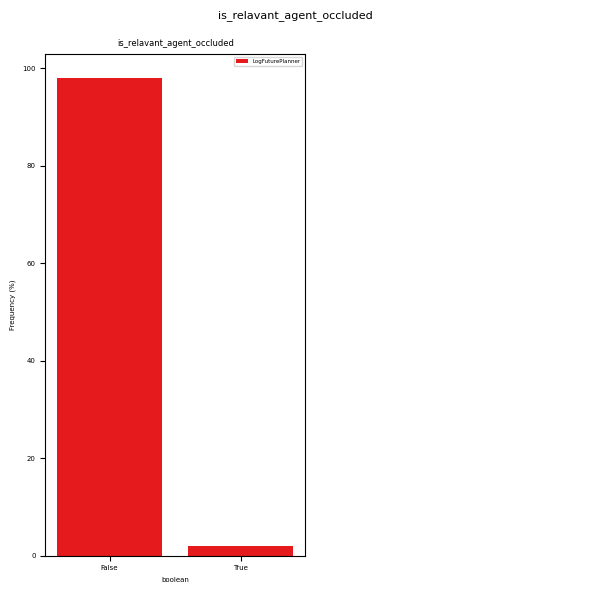

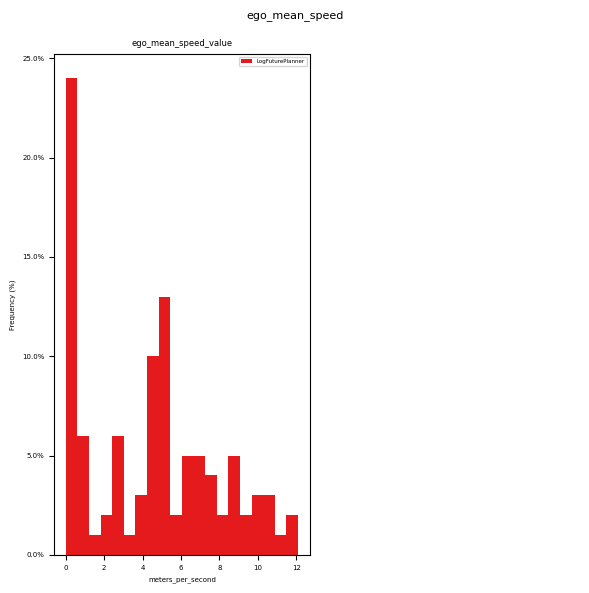

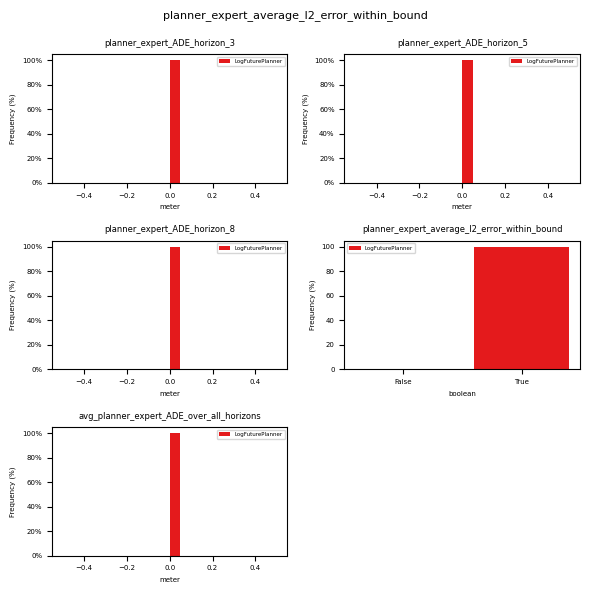

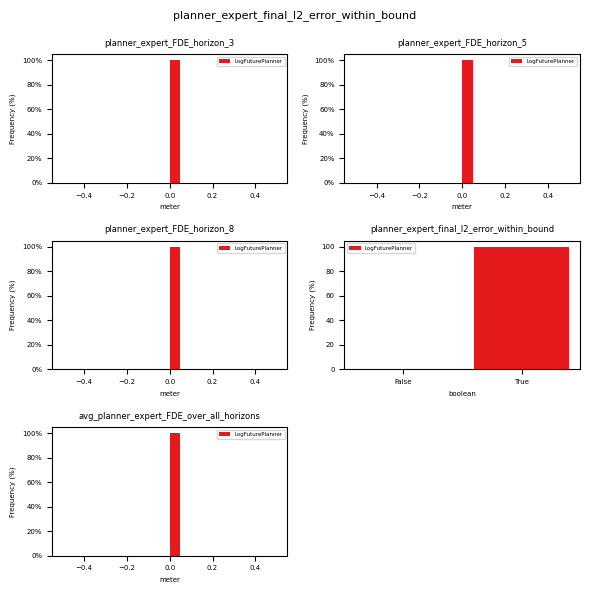

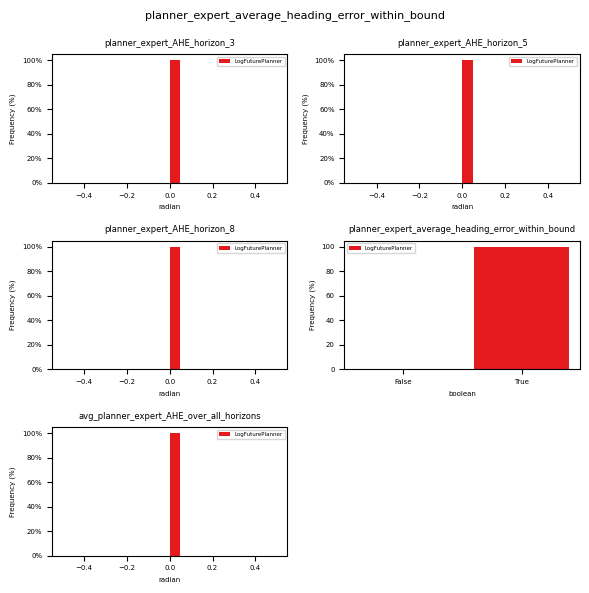

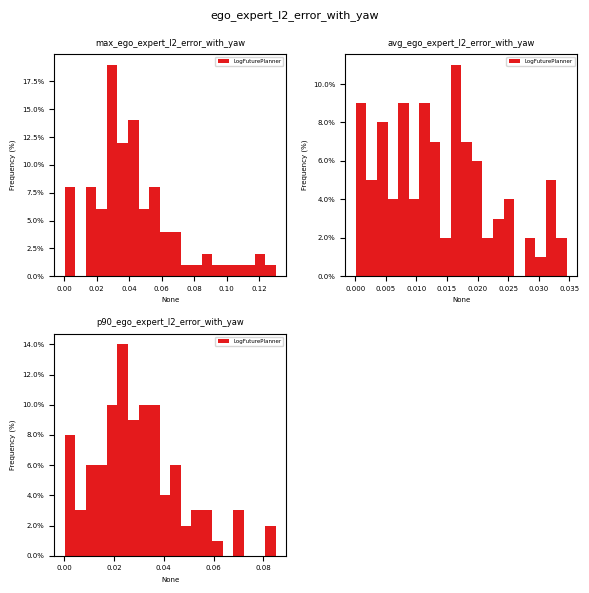

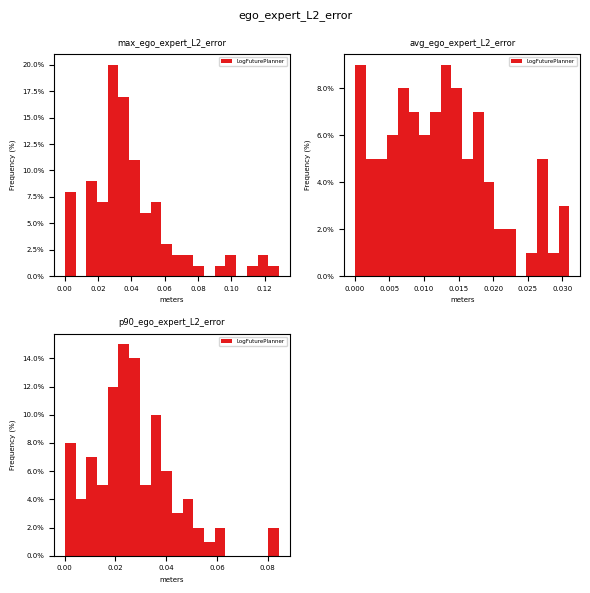

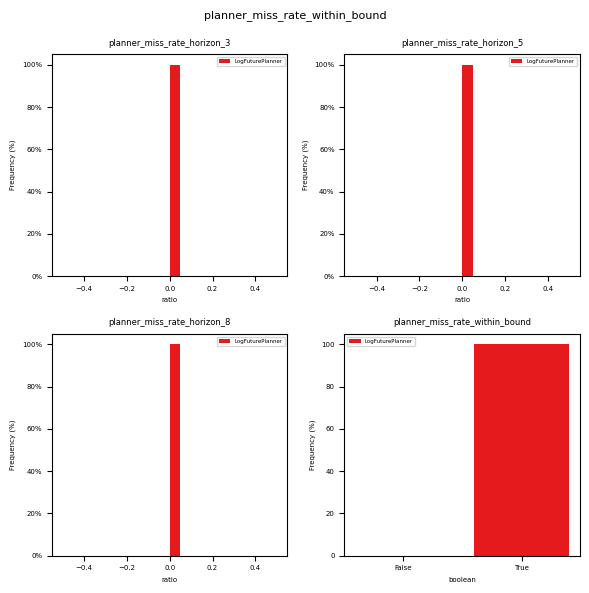

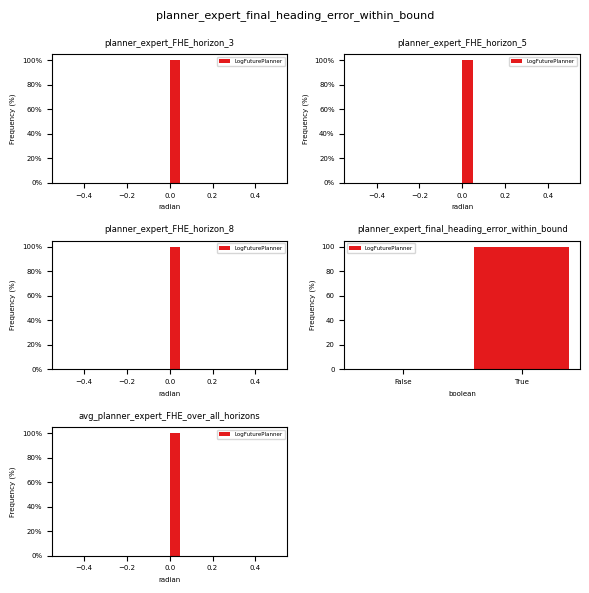

In [9]:
from nuplan.planning.script.run_simulation import main as main_simulation

# Run the simulation loop (real-time visualization not yet supported, see next section for visualization)
main_simulation(cfg)

## Prepare the nuBoard config

In [7]:
# Location of path with all nuBoard configs
CONFIG_PATH = '../nuplan/planning/script/config/nuboard'
CONFIG_NAME = 'default_nuboard'

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[
    'scenario_builder=nuplan_mini',  # set the database (same as simulation) used to fetch data for visualization
    f'simulation_path={[output_folder]}',  # nuboard file path(s), if left empty the user can open the file inside nuBoard
])


## Launch nuBoard (open in new tab - recommended)

In [8]:
from nuplan.planning.script.run_nuboard import main as main_nuboard

# Run nuBoard
main_nuboard(cfg)

2023-12-09 00:00:07,547 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:18}  Building AbstractScenarioBuilder...
2023-12-09 00:00:07,558 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:21}  Building AbstractScenarioBuilder...DONE!
2023-12-09 00:00:07,558 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:84}  Opening Bokeh application on http://localhost:5006/
2023-12-09 00:00:07,559 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:85}  Async rendering is set to: True
2023-12-09 00:00:07,559 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/server.py:403}  Starting Bokeh server version 2.4.3 (running on Tornado 6.3.3)
2023-12-09 00:00:07,559 WARNING {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/util.py:145}  Host wildcard '*' will allow connections originating from multiple (or possib

INFO:tornado.access:200 GET / (127.0.0.1) 179.44ms
INFO:tornado.access:304 GET /resource/spectre.min.css (127.0.0.1) 2.81ms
INFO:tornado.access:304 GET /resource/spectre-icons.min.css (127.0.0.1) 0.26ms
INFO:tornado.access:304 GET /resource/style.css (127.0.0.1) 0.28ms
INFO:tornado.access:304 GET /resource/spectre-exp.min.css (127.0.0.1) 0.35ms
INFO:tornado.access:304 GET /resource/css/overview.css (127.0.0.1) 0.26ms
INFO:tornado.access:304 GET /resource/css/cloud.css (127.0.0.1) 0.31ms
INFO:tornado.access:304 GET /resource/css/scenario.css (127.0.0.1) 0.30ms
INFO:tornado.access:304 GET /resource/css/histogram.css (127.0.0.1) 0.26ms
INFO:tornado.access:304 GET /resource/scripts/utils.js (127.0.0.1) 0.28ms
INFO:tornado.access:304 GET /resource/motional_logo.png (127.0.0.1) 6.79ms


2023-12-09 00:00:08,421 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  304 GET /resource/css/cloud.css (127.0.0.1) 0.31ms
2023-12-09 00:00:08,422 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  304 GET /resource/css/scenario.css (127.0.0.1) 0.30ms
2023-12-09 00:00:08,430 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  304 GET /resource/css/histogram.css (127.0.0.1) 0.26ms
2023-12-09 00:00:08,433 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  304 GET /resource/scripts/utils.js (127.0.0.1) 0.28ms
2023-12-09 00:00:08,447 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  304 GET /resource/motional_logo.png (127.0.0.1) 6.79ms
2023-12-09 00:00:09,222 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:172}  Minimum frame time=0.017 s
2

INFO:tornado.access:200 GET / (127.0.0.1) 154.42ms
INFO:tornado.access:101 GET /ws (127.0.0.1) 0.58ms
